Epoch 1, Loss: 0.6947
Epoch 2, Loss: 0.6836
Epoch 3, Loss: 0.6692
Epoch 4, Loss: 0.6511
Epoch 5, Loss: 0.6415
Epoch 6, Loss: 0.6350
Epoch 7, Loss: 0.6288
Epoch 8, Loss: 0.6234
Epoch 9, Loss: 0.6202
Epoch 10, Loss: 0.6104
Epoch 11, Loss: 0.6027
Epoch 12, Loss: 0.5977
Epoch 13, Loss: 0.5917
Epoch 14, Loss: 0.5906
Epoch 15, Loss: 0.5830
Epoch 1, Loss: 0.6853
Epoch 2, Loss: 0.6767
Epoch 3, Loss: 0.6684
Epoch 4, Loss: 0.6578
Epoch 5, Loss: 0.6448
Epoch 6, Loss: 0.6339
Epoch 7, Loss: 0.6227
Epoch 8, Loss: 0.6115
Epoch 9, Loss: 0.6024
Epoch 10, Loss: 0.5954
Epoch 11, Loss: 0.5896
Epoch 12, Loss: 0.5827
Epoch 13, Loss: 0.5791
Epoch 14, Loss: 0.5763
Epoch 15, Loss: 0.5688

--- CNN Predicted Blind Spots ---


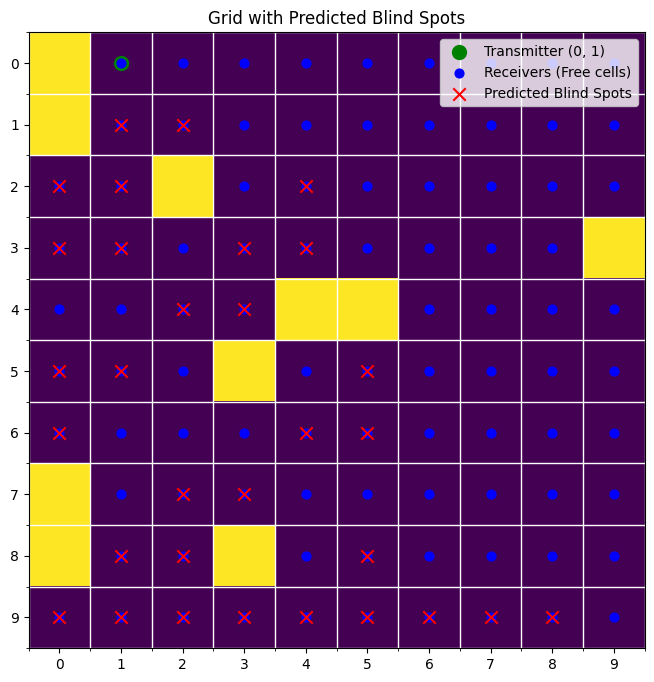

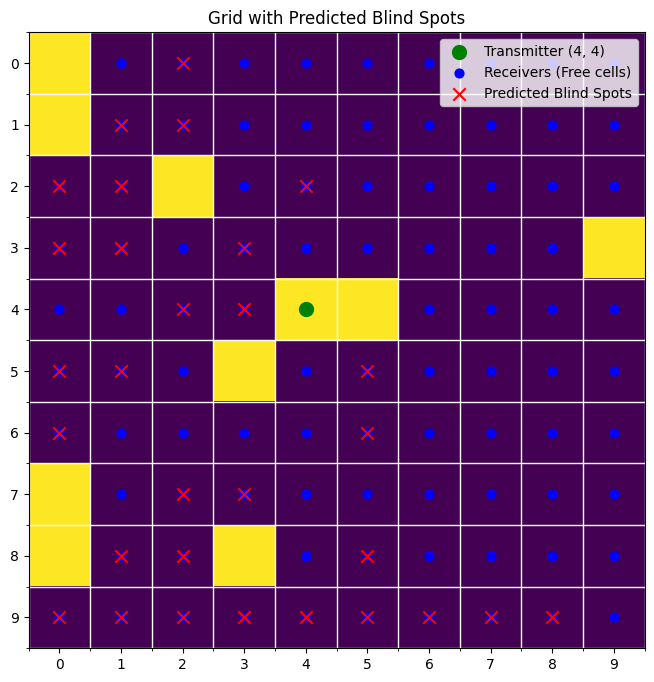

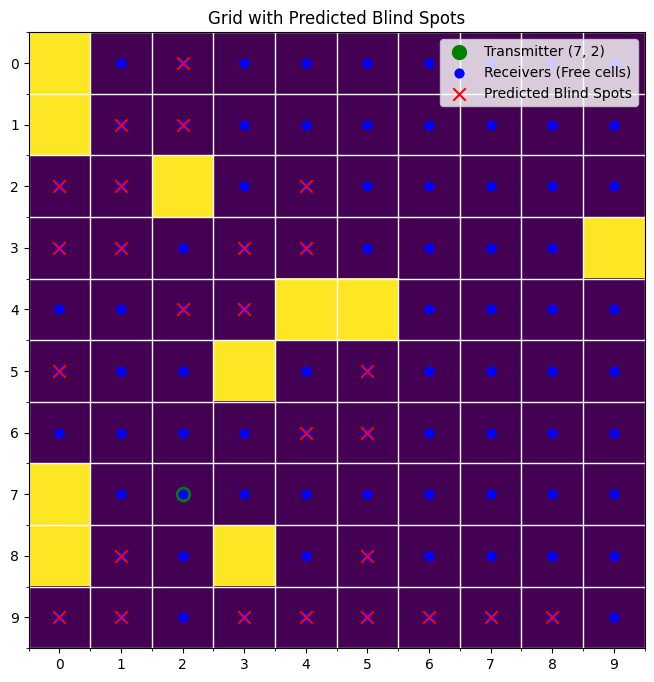


--- CNN Predicted Coverage Maps ---


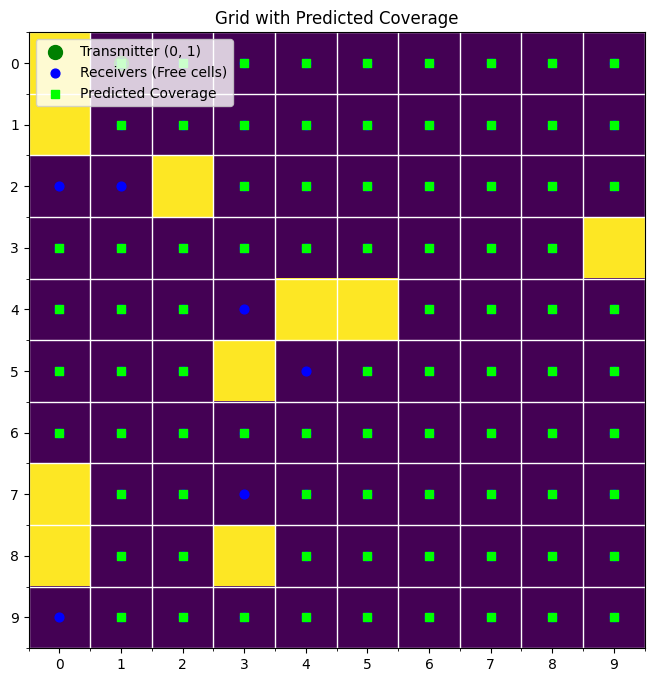

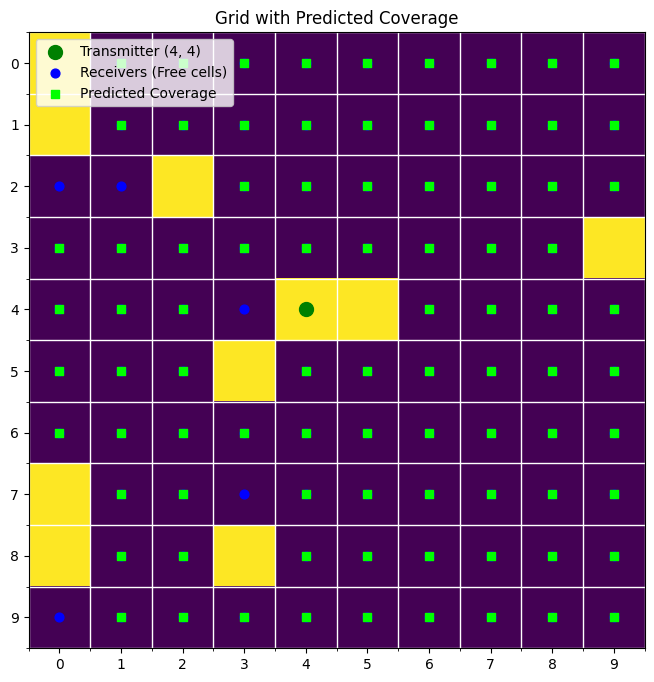

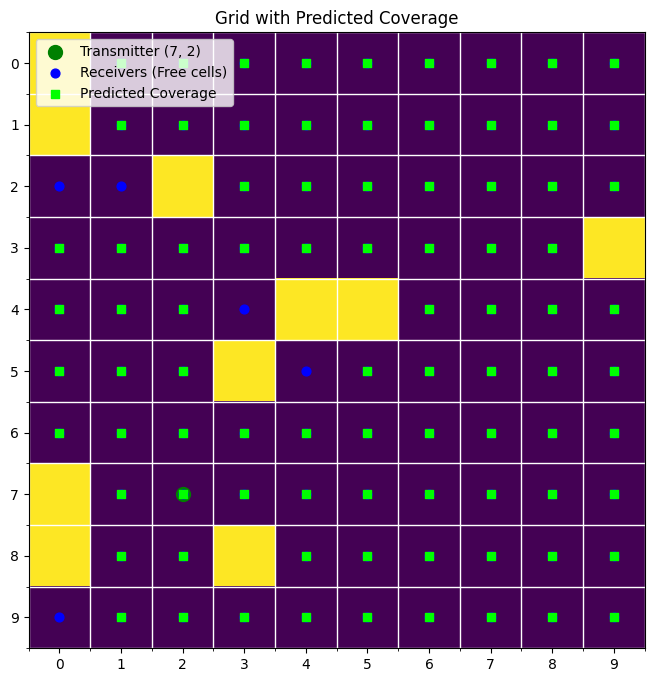

In [ ]:
# ========== Imports ==========
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ========== Grid Functions ==========
def create_grid(A, M, obstacle_prob=0.1):
    N = int(np.sqrt(M))
    grid = np.zeros((N, N), dtype=int)
    num_obstacles = int(M * obstacle_prob)
    obstacle_positions = np.random.choice(M, num_obstacles, replace=False)
    for pos in obstacle_positions:
        grid[pos // N, pos % N] = 1
    return grid

def supercover_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2
    for _ in range(n):
        points.append((x, y))
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
    rows, cols = zip(*points)
    return np.array(rows), np.array(cols)

def coverage(grid, tx):
    covered = np.zeros_like(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 0:
                rx = (i, j)
                path_rows, path_cols = supercover_line(tx[0], tx[1], rx[0], rx[1])
                if not np.any(grid[path_rows, path_cols] == 1):
                    covered[path_rows, path_cols] = 1
                else:
                    covered[rx[0], rx[1]] = 0
    return covered

def count_blind_spots(grid, covered):
    return np.sum((grid == 0) & (covered == 0))

# ========== Dataset Classes ==========
class BlindSpotDataset(Dataset):
    def __init__(self, grid, samples=200):
        self.grid = grid
        self.data = []
        self.labels = []
        self.samples = samples
        self.generate_dataset()

    def generate_dataset(self):
        free_cells = np.argwhere(self.grid == 0)
        np.random.shuffle(free_cells)
        for i in range(min(self.samples, len(free_cells))):
            tx = tuple(free_cells[i])
            input_grid = self.encode_input(self.grid, tx)
            target = self.encode_blind_label(coverage(self.grid, tx))
            self.data.append(input_grid)
            self.labels.append(target)

    def encode_input(self, grid, tx):
        obstacle = (grid == 1).astype(np.float32)
        transmitter = np.zeros_like(grid, dtype=np.float32)
        transmitter[tx[0], tx[1]] = 1.0
        free_space = (grid == 0).astype(np.float32)
        stacked = np.stack([obstacle, transmitter, free_space], axis=0)
        return stacked

    def encode_blind_label(self, covered):
        blind = ((self.grid == 0) & (covered == 0)).astype(np.float32)
        return blind[np.newaxis, :, :]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

class CoverageDataset(BlindSpotDataset):
    def encode_blind_label(self, covered):
        return covered[np.newaxis, :, :].astype(np.float32)

# ========== CNN ==========
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ========== Training & Testing ==========
def train_model(model, loader, epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

def test_model(model, test_sample):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(test_sample).unsqueeze(0)
        output = model(input_tensor).squeeze().numpy()
        return output

# ========== Visualization ==========
def plot_predicted_grid(grid, tx, prediction, mode='blind', threshold=0.5):
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap='viridis')
    plt.grid(visible=True, color='white', linewidth=1, which='minor')
    plt.xticks(np.arange(grid.shape[1]), labels=np.arange(grid.shape[1]))
    plt.yticks(np.arange(grid.shape[0]), labels=np.arange(grid.shape[0]))
    plt.xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    plt.yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)

    plt.scatter(tx[1], tx[0], color='green', s=100, label=f"Transmitter {tx}")
    rx_free = np.argwhere(grid == 0)
    plt.scatter(rx_free[:, 1], rx_free[:, 0], color='blue', s=40, label="Receivers (Free cells)")

    if mode == 'blind':
        blind_spots = np.argwhere((grid == 0) & (prediction > threshold))
        plt.scatter(blind_spots[:, 1], blind_spots[:, 0], color='red', marker='x', s=80, label='Predicted Blind Spots')
    elif mode == 'coverage':
        coverage_cells = np.argwhere((grid == 0) & (prediction > threshold))
        plt.scatter(coverage_cells[:, 1], coverage_cells[:, 0], color='lime', marker='s', s=40, label='Predicted Coverage')

    plt.title(f"Grid with Predicted {'Blind Spots' if mode == 'blind' else 'Coverage'}")
    plt.legend()
    plt.show()

# ========== Execution ==========
A = 10
M = 100
np.random.seed(42)
grid = create_grid(A, M, obstacle_prob=0.1)

# Train Blind Spot Model
blind_dataset = BlindSpotDataset(grid, samples=300)
blind_loader = DataLoader(blind_dataset, batch_size=16, shuffle=True)
blind_model = CNN()
train_model(blind_model, blind_loader, epochs=15)

# Train Coverage Model
cov_dataset = CoverageDataset(grid, samples=300)
cov_loader = DataLoader(cov_dataset, batch_size=16, shuffle=True)
cov_model = CNN()
train_model(cov_model, cov_loader, epochs=15)

# Test on Multiple Transmitter Locations
tx_list = [(0,1), (4,4), (7,2)]

print("\n--- CNN Predicted Blind Spots ---")
for tx in tx_list:
    input_grid = blind_dataset.encode_input(grid, tx)
    prediction = test_model(blind_model, input_grid)
    plot_predicted_grid(grid, tx, prediction, mode='blind', threshold=0.4)

print("\n--- CNN Predicted Coverage Maps ---")
for tx in tx_list:
    input_grid = cov_dataset.encode_input(grid, tx)
    prediction = test_model(cov_model, input_grid)
    plot_predicted_grid(grid, tx, prediction, mode='coverage', threshold=0.4)
